KIẾN TRÚC CHÍNH:
1. Tensor Product (TP): Kết hợp node features với spherical harmonics
2. Edge MLP: Học weights cho tensor product từ edge attributes
3. Self-interaction: Cho phép node cập nhật dựa trên chính nó
4. Normalization: Ổn định quá trình training
5. Residual Connection: Cải thiện gradient flow

IRREPS (Irreducible Representations):
- irreps_in: Biểu diễn của input features (vd: "16x0e + 8x1o + 4x2e")
  + 0e: scalar features (không đổi khi xoay)
  + 1o: vector features (xoay theo hệ tọa độ) 
  + 2e: tensor features bậc 2
- irreps_sh: Biểu diễn của spherical harmonics
- irreps_out: Biểu diễn của output features

TENSOR PRODUCT:
Message = TP(node_features, spherical_harmonics) × edge_weights
Cho phép học các tương tác phụ thuộc hướng một cách equivariant

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
from e3nn import o3
from e3nn.nn import BatchNorm
from e3nn.o3 import FullyConnectedTensorProduct, Linear
from torch_scatter import scatter



In [2]:
def create_molecule_graph(n_atoms=10):
    """    
    Returns:
        pos: [N, 3] - Tọa độ các nguyên tử
        edge_index: [2, E] - Các cạnh kết nối
        atom_types: [N] - Loại nguyên tử (giả lập)
    """
    
    # Tạo tọa độ ngẫu nhiên cho các nguyên tử
    np.random.seed(42)
    pos = torch.randn(n_atoms, 3) * 2.0
    
    # Tạo edges dựa trên khoảng cách (nối các nguyên tử gần nhau)
    distances = torch.cdist(pos, pos)
    threshold = 3.0
    adj_matrix = (distances < threshold) & (distances > 0)
    edge_index = torch.stack(torch.where(adj_matrix))
    
    # Loại nguyên tử (C, N, O, H)
    atom_types = torch.randint(0, 4, (n_atoms,))
    
    return pos, edge_index, atom_types

In [3]:
def compute_spherical_harmonics(pos, edge_index, lmax=2):
    """
    Tính spherical harmonics cho các edge vectors
    
    Args:
        pos: [N, 3] - vị trí nodes
        edge_index: [2, E] - edge indices
        lmax: bậc tối đa của spherical harmonics
        
    Returns:
        edge_sh: [E, (lmax+1)^2] - spherical harmonics
        edge_vec: [E, 3] - edge vectors
        edge_length: [E] - độ dài edges
    """
    src, dst = edge_index
    edge_vec = pos[dst] - pos[src]  # Vector từ src đến dst
    edge_length = torch.norm(edge_vec, dim=1, keepdim=True)
    
    # Normalize vectors
    edge_dir = edge_vec / (edge_length + 1e-8)
    
    edge_sh = o3.spherical_harmonics(
            list(range(lmax + 1)), 
            edge_dir, 
            normalize=True
        )
    
    return edge_sh, edge_vec, edge_length.squeeze()

In [4]:
def visualize_molecule_3d(pos, edge_index, atom_types=None, features=None, 
                          title="Molecular Graph"):
    """Vẽ đồ thị phân tử 3D"""
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Vẽ nodes (atoms)
    if atom_types is not None:
        colors = ['red', 'blue', 'green', 'orange']
        labels = ['C', 'N', 'O', 'H']
        for i, atom_type in enumerate(torch.unique(atom_types)):
            mask = atom_types == atom_type
            ax.scatter(pos[mask, 0], pos[mask, 1], pos[mask, 2], 
                      c=colors[atom_type], s=300, alpha=0.8, 
                      label=labels[atom_type], edgecolors='black', linewidths=2)
    else:
        ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], 
                  c='blue', s=300, alpha=0.8, edgecolors='black', linewidths=2)
    
    # Vẽ edges (bonds)
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[0, i], edge_index[1, i]
        ax.plot([pos[src, 0], pos[dst, 0]],
                [pos[src, 1], pos[dst, 1]],
                [pos[src, 2], pos[dst, 2]], 
                'k-', alpha=0.3, linewidth=1)
    
    # Nếu có features, vẽ màu theo features
    if features is not None:
        feature_magnitude = torch.norm(features, dim=1).detach().numpy()
        scatter = ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], 
                           c=feature_magnitude, s=500, alpha=0.6, 
                           cmap='coolwarm', edgecolors='black', linewidths=2)
        plt.colorbar(scatter, ax=ax, label='Feature Magnitude')
    
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend()
    
    return fig, ax

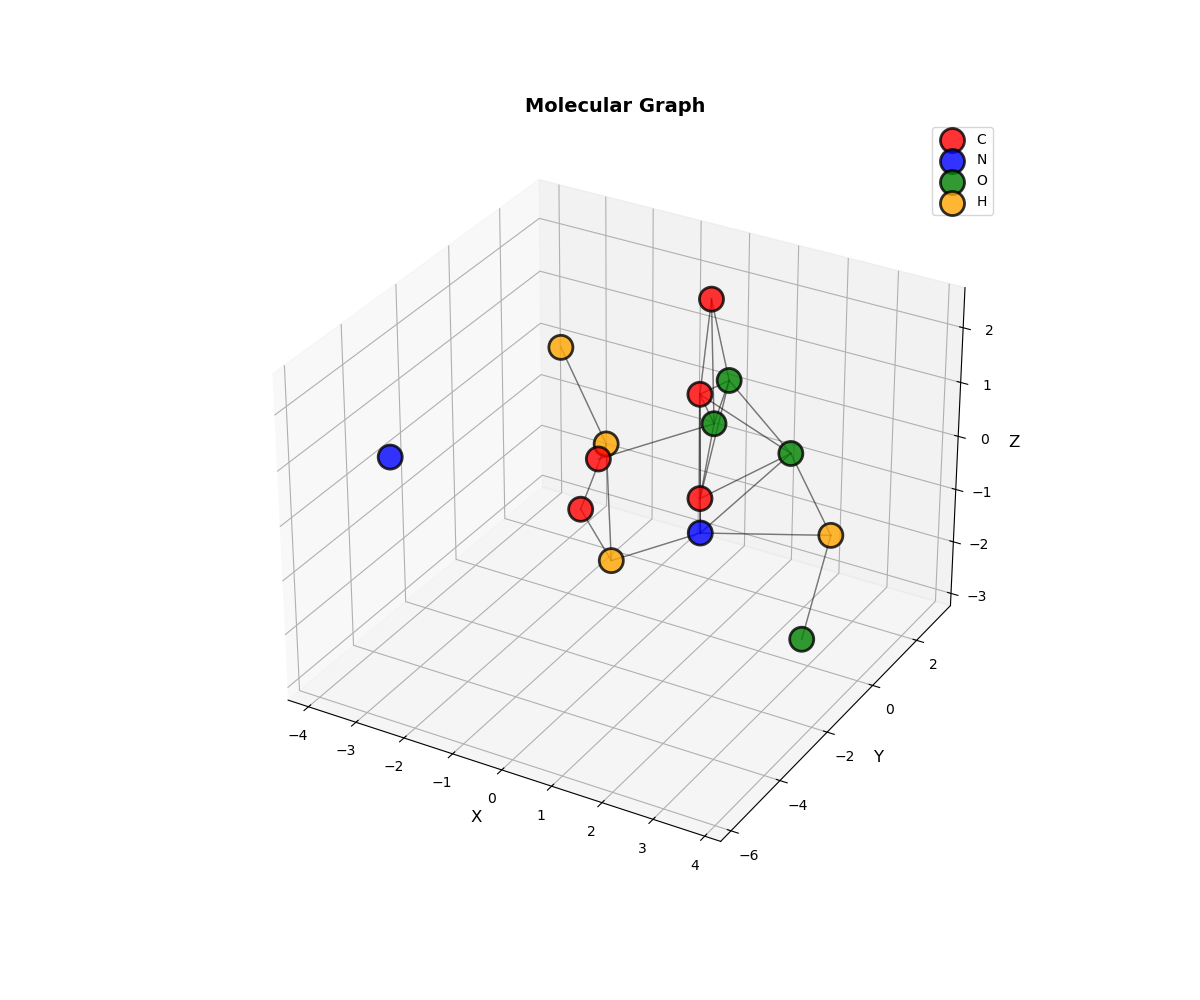

In [7]:
%matplotlib widget
n_atoms = 15
pos, edge_index, atom_types = create_molecule_graph(n_atoms)
fig, ax = visualize_molecule_3d(pos, edge_index, atom_types)

In [ ]:
class SphericalHarmonicsConvolution(nn.Module):
    """
    E(3) equivariant convolution layer using spherical harmonics
    with normalization for stability
    """
    def __init__(self, irreps_in, irreps_out, irreps_sh, edge_attr_dim=0, 
                 hidden_dim=64, residual=True, normalization='layer'):
        super().__init__()
        
        self.irreps_in = o3.Irreps(irreps_in)
        self.irreps_out = o3.Irreps(irreps_out)
        self.irreps_sh = o3.Irreps(irreps_sh)
        self.residual = residual and (self.irreps_in == self.irreps_out)
        
        # Tensor product: node features x spherical harmonics -> messages
        self.tp = FullyConnectedTensorProduct(
            self.irreps_in,
            self.irreps_sh,
            self.irreps_out,
            shared_weights=False
        )
        
        # MLP for edge weights
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_attr_dim , hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, self.tp.weight_numel)
        )
        
        # Self-interaction
        self.self_interaction = Linear(self.irreps_in, self.irreps_out)
        
        # Normalization for stability
        if normalization == 'layer':
            self.norm = BatchNorm(self.irreps_out)
        elif normalization == 'instance':
            self.norm = BatchNorm(self.irreps_out, instance=True)
        else:
            self.norm = None
            
    def forward(self, h, edge_index, edge_sh, edge_attr, 
                edge_length_embedded, batch_mask=None):
        """
        Args:
            h: [N, irreps_in.dim] - node features
            edge_index: [2, E] - edge indices
            edge_sh: [E, irreps_sh.dim] - spherical harmonics
            edge_attr: [E, edge_attr_dim] - edge attributes
            edge_length_embedded: [E, edge_embed_dim] - embedded edge lengths
            batch_mask: [N] - batch indices for normalization
        """
        src, dst = edge_index
        
        # Compute edge weights from edge attributes
        edge_weight_input = torch.cat([edge_attr, edge_length_embedded], dim=-1)
        edge_weights = self.edge_mlp(edge_weight_input)
        
        # Message passing: tensor product of source features and spherical harmonics
        messages = self.tp(h[src], edge_sh, edge_weights)
        
        # Aggregate messages
        out = scatter(messages, dst, dim=0, dim_size=h.shape[0], reduce='mean')
        
        # Self-interaction
        out = out + self.self_interaction(h)
        
        # Normalization for stability
        if self.norm is not None:
            out = self.norm(out)
        
        # Residual connection
        if self.residual:
            out = out + h
            
        return out
def run_convolution_demo():
    """Demo forward pass của SphericalHarmonicsConvolution"""
    
    print("="*70)
    print("DEMO: SphericalHarmonicsConvolution Forward Pass")
    print("="*70)
    
    # Tạo dữ liệu
    n_atoms = 15
    pos, edge_index, atom_types = create_molecule_graph(n_atoms)
    
    print(f"\n📊 Dữ liệu đầu vào:")
    print(f"  - Số atoms: {n_atoms}")
    print(f"  - Số edges: {edge_index.shape[1]}")
    print(f"  - Tọa độ shape: {pos.shape}")
    
    lmax = 2
    edge_sh, edge_vec, edge_length = compute_spherical_harmonics(pos, edge_index, lmax)
    print(f"\n🌐 Spherical Harmonics:")
    print(f"  - lmax: {lmax}")
    print(f"  - Shape: {edge_sh.shape}")
    print(f"  - Số harmonics: {(lmax+1)**2} = {[i**2 for i in range(lmax+2)]}")
    # === VỚI E3NN ===
    # Định nghĩa irreps
    irreps_in = "16x0e + 8x1o + 4x2e"  # 16 scalars + 8 vectors + 4 rank-2 tensors
    irreps_out = "16x0e + 8x1o + 4x2e"
    irreps_sh = o3.Irreps.spherical_harmonics(lmax)
    
    print(f"\n🎯 Irreducible Representations:")
    print(f"  - Input:  {irreps_in}")
    print(f"  - Output: {irreps_out}")
    print(f"  - SH:     {irreps_sh}")
        
    layer = SphericalHarmonicsConvolution(
        irreps_in=irreps_in,
        irreps_out=irreps_out,
        irreps_sh=irreps_sh,
        edge_attr_dim=8,
        hidden_dim=64,
        residual=True,
        normalization='layer'
    )
    
    # Tạo input features với đúng dimension
    h = o3.Irreps(irreps_in).randn(n_atoms, -1)
    edge_attr = torch.randn(edge_index.shape[1], 8)
    edge_length_embedded = torch.randn(edge_index.shape[1], 16)
    
    print(f"\n🔄 Forward Pass:")
    print(f"  Input shape: {h.shape}")
    
    # Forward pass
    with torch.no_grad():
        h_out = layer(h, edge_index, edge_sh, edge_attr, edge_length_embedded)
    
    print(f"  Output shape: {h_out.shape}")
    print(f"  ✅ Forward pass thành công!")
    
    # Visualizations
    fig1, _ = visualize_molecule_3d(pos, edge_index, atom_types,
                                    title="Input Molecular Graph")
    plt.tight_layout()
    plt.show()
    
    fig2, _ = visualize_molecule_3d(pos, edge_index, atom_types, features=h,
                                    title="Input Features")
    plt.tight_layout()
    plt.show()
    
    fig3, _ = visualize_molecule_3d(pos, edge_index, atom_types, features=h_out,
                                    title="Output Features (After Convolution)")
    plt.tight_layout()
    plt.show()

In [12]:
def visualize_spherical_harmonics():
    """Vẽ các spherical harmonics functions"""
    
    fig = plt.figure(figsize=(15, 10))
    
    # Tạo grid trên mặt cầu
    theta = np.linspace(0, np.pi, 50)
    phi = np.linspace(0, 2*np.pi, 50)
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # Convert sang Cartesian
    x = np.sin(theta_grid) * np.cos(phi_grid)
    y = np.sin(theta_grid) * np.sin(phi_grid)
    z = np.cos(theta_grid)
    
    # Stack thành vectors
    vectors = torch.tensor(np.stack([x.flatten(), y.flatten(), z.flatten()], axis=1), 
                          dtype=torch.float32)
    
    # Tính spherical harmonics
    lmax = 2
    sh = o3.spherical_harmonics(list(range(lmax + 1)), vectors, normalize=True)
    
    # Vẽ một số harmonics
    harmonics_to_plot = [0, 1, 2, 3, 4, 8]  # l=0,m=0; l=1,m=-1,0,1; l=2,m=0
    
    for idx, sh_idx in enumerate(harmonics_to_plot):
        ax = fig.add_subplot(2, 3, idx+1, projection='3d')
        
        # Lấy giá trị của harmonic này
        values = sh[:, sh_idx].numpy().reshape(50, 50)
        
        # Vẽ surface với màu theo giá trị
        surf = ax.plot_surface(x, y, z, facecolors=plt.cm.seismic(values),
                              alpha=0.8, linewidth=0)
        
        # Tính l và m từ index
        l = int(np.sqrt(sh_idx))
        m = sh_idx - l**2 - l
        
        ax.set_title(f'Y({l},{m})', fontsize=12, fontweight='bold')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_box_aspect([1,1,1])
    
    plt.suptitle('Spherical Harmonics Visualization', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

1. TENSOR PRODUCT (FullyConnectedTensorProduct):
   ─────────────────────────────────────────────
   Kết hợp node features với spherical harmonics:
   
   Message = TP(h_source, SH(edge_direction)) × edge_weights
   
   - Input 1: Node features (có thể là scalar, vector, tensor)
   - Input 2: Spherical harmonics (mã hóa hướng của edge)
   - Output: Messages với đúng symmetry properties
   
   Ví dụ:
   - Scalar × Vector = Vector
   - Vector × Vector = Scalar + Vector + Tensor
   - Tuân theo quy tắc Clebsch-Gordan

2. EDGE MLP:
   ──────────
   Học weights cho tensor product từ edge attributes:
   
   edge_weights = MLP(edge_attr + edge_length_embedded)
   
   - Input: Edge features (khoảng cách, loại bond, ...)
   - Output: Weights để điều chỉnh messages
   - Cho phép model học quan trọng khác nhau của edges

3. SELF-INTERACTION:
   ──────────────────
   Cho phép node cập nhật dựa trên chính nó:
   
   out = messages_aggregated + self_interaction(h)
   
   - Giống như "skip connection" trong ResNet
   - Giúp node giữ lại thông tin gốc
   - Cải thiện gradient flow

4. NORMALIZATION:
   ───────────────
   Ổn định training:
   
   - Layer Norm: Normalize theo features
   - Instance Norm: Normalize theo từng sample
   - Tránh exploding/vanishing activations

5. RESIDUAL CONNECTION:
   ─────────────────────
   out = out + h (nếu irreps_in == irreps_out)
   
   - Giúp training sâu hơn
   - Tránh degradation problem
   - Model học residual (delta) thay vì full output

6. MESSAGE AGGREGATION:
   ─────────────────────
   Tổng hợp messages từ neighbors:
   
   h_new[i] = Σ_{j∈N(i)} message_{j→i}
   
   - Mean: Trung bình (không phụ thuộc số neighbors)
   - Sum: Tổng (phụ thuộc số neighbors)
   - Max: Lấy max (robust to outliers)
    """)

In [13]:

print("\n\n🚀 Chạy forward pass demo...")
run_convolution_demo()

# 4. Visualize spherical harmonics
print("\n\n🌐 Visualize spherical harmonics...")
visualize_spherical_harmonics()

print("\n✅ Demo hoàn tất!")
print("\n📚 Để hiểu sâu hơn, xem:")
print("   - Paper: 'E(3)-equivariant graph neural networks'")
print("   - e3nn documentation: https://docs.e3nn.org/")
print("   - Spherical harmonics: https://en.wikipedia.org/wiki/Spherical_harmonics")



🚀 Chạy forward pass demo...
DEMO: SphericalHarmonicsConvolution Forward Pass

📊 Dữ liệu đầu vào:
  - Số atoms: 15
  - Số edges: 40
  - Tọa độ shape: torch.Size([15, 3])

🌐 Spherical Harmonics:
  - lmax: 2
  - Shape: torch.Size([40, 9])
  - Số harmonics: 9 = [0, 1, 4, 9]

🎯 Irreducible Representations:
  - Input:  16x0e + 8x1o + 4x2e
  - Output: 16x0e + 8x1o + 4x2e
  - SH:     1x0e+1x1o+1x2e

🔄 Forward Pass:
  Input shape: torch.Size([15, 60])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (40x24 and 8x64)